In [1]:
import pandas as pd
from collections import Counter


In [2]:
df = pd.read_csv("ex3.csv")
df.head()

,idx,line,bar,mdur,bdur,beat,abs,1b40,1attk,1last,...,2last,2next,3b40,3attk,3last,3next,4b40,4attk,4last,4next
0,0,2000,3000,3100,3200,4000,5000,1040,7100,7200,...,7200,7300,1040,7100,7200,7300,1040,7100,7200,7300
1,1,19,1,8,4,0,0,145,1,-1,...,-1,2,168,1,-1,2,185,1,-1,2
2,2,20,1,8,4,4,4,145,2,1,...,1,3,168,2,1,3,185,2,1,3
3,3,22,2,8,4,0,8,128,3,2,...,2,4,168,3,2,4,191,3,2,4
4,4,23,2,8,4,4,12,145,4,3,...,3,6,0,4,3,5,197,4,3,6


### Goal: count how many whole notes there are, per voice

First: create a list with the abs location of each note per voice (ignoring difference between rests and voices)

In [3]:
num_voices = 4
voices = []
for n in range(1,num_voices+1):
    voices.append(str(n)+'b40')

In [17]:
rhythm_cols = ['beat', 'abs']+voices
rhythm_data = df[rhythm_cols]

In [18]:
rhythm_beat = []
rhythm_abs = []
for v in range(num_voices):
    notes = []
    beats = []
    for i in rhythm_data.index:
        if rhythm_data[voices[v]].iloc[i] >= 0:
            next_note = rhythm_data.iloc[i]['abs']
            next_beat = rhythm_data.iloc[i]['beat']
            notes.append(next_note)
            beats.append(next_beat)
    rhythm_abs.append(notes)
    rhythm_beat.append(beats)
    rhythm_abs[v], rhythm_beat[v] = rhythm_abs[v][1:], rhythm_beat[v][1:]    

In [19]:
rhythm_durs = []
for v in range(num_voices):
    durs = [rhythm_abs[v][i+1] - rhythm_abs[v][i] for i in range(len(rhythm_abs[v])-1)]
    durs.append(0)
    rhythm_durs.append(durs)

In [120]:
rhythm_df = []
for v in range(num_voices):
    rhythm_df.append(pd.DataFrame({
        str(v)+'beat' : rhythm_beat[v], 
        str(v)+'abs' : rhythm_abs[v], 
        str(v)+'durs' : rhythm_durs[v]
    }))
  
new_df = rhythm_df[0].transpose()
new_df.columns = (new_df.loc['0abs'])
new_df = new_df.drop('0abs')
new_df

0abs,0,4,8,12,16,20,24,28,32,38,...,256,264,268,276,280,288,292,296,304,316
0beat,0,4,0,4,0,4,0,4,0,6,...,0,8,0,8,0,8,0,4,0,0
0durs,4,4,4,4,4,4,4,4,6,2,...,8,4,8,4,8,4,4,8,12,0


In [194]:
rhythm_counts = []
rhythm_options = set()
for v in range(num_voices):
    rhythm_counts.append(rhythm_df[v][str(v)+'durs'].value_counts())
    rhythm_options = rhythm_options.union(set(rhythm_counts[v].index))

rhythm_counts_df = pd.DataFrame(
    {'Voice'+str(v) : rhythm_counts[v] for v in range(num_voices)}, 
    index=rhythm_options)
rhythm_counts_df.fillna(0, inplace=True) # replace NaN with 0
rhythm_counts_df = rhythm_counts_df.astype(int) # turn everything back into int64

rhythm_counts_df = rhythm_counts_df.transpose()
rhythm_counts_df

,0,1,2,3,4,6,8,12
Voice0,1,0,15,0,42,3,11,1
Voice1,1,5,12,3,41,5,9,1
Voice2,1,0,15,0,42,3,11,1
Voice3,1,4,14,2,41,5,9,1


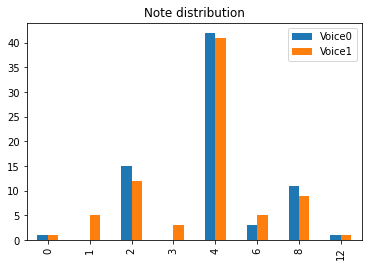

In [132]:
rhythm_counts_df.transpose().plot(kind='bar',title='Note distribution', y=['Voice0', 'Voice1'])

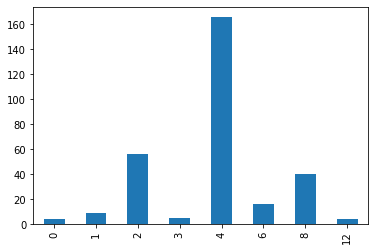

In [153]:
total_counts = pd.Series(
    [sum(rhythm_counts_df[l]) for l in rhythm_counts_df.columns],
    name="total", index = rhythm_counts_df.columns)
total_counts.plot(kind='bar')

In [177]:
rhythm_counts_df_t = rhythm_counts_df.append(total_counts)
rhythm_counts_df_t

,0,1,2,3,4,6,8,12
Voice0,1,0,15,0,42,3,11,1
Voice1,1,5,12,3,41,5,9,1
Voice2,1,0,15,0,42,3,11,1
Voice3,1,4,14,2,41,5,9,1
total,4,9,56,5,166,16,40,4


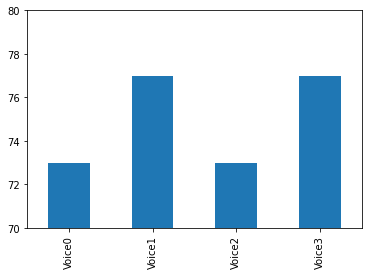

In [204]:
total_notes = pd.Series(
    [sum(rhythm_counts_df.loc[v]) for v in rhythm_counts_df.index],
    name='total notes', index = rhythm_counts_df.index)
total_notes.plot(kind='bar', ylim = (70,80))

total_notes_t = pd.Series(
    [sum(rhythm_counts_df_t.loc[v]) for v in rhythm_counts_df_t.index],
    name='total notes', index = rhythm_counts_df_t.index)

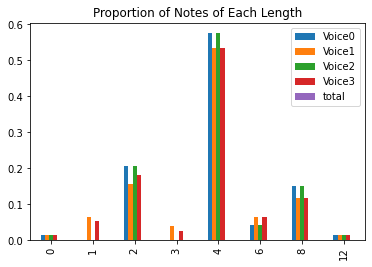

In [207]:
rhythm_counts_rel = rhythm_counts_df_t.astype(float).div(total_notes,axis=0)
rhythm_counts_rel.transpose().plot(
    kind='bar', 
    # y = list(set(rhythm_counts_rel.index) - {'total'}),
    title = 'Proportion of Notes of Each Length',
    # logy=True
)